<a href="https://colab.research.google.com/github/aryan-at-ul/customer_segmentation/blob/main/clustering_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data_path = "/content/drive/MyDrive/customer_segmentation/bank-full.csv"
#one can download csv from public folder and use it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import scipy 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import linecache
import os
import tracemalloc
from datetime import datetime
from queue import Queue, Empty
from resource import getrusage, RUSAGE_SELF
from threading import Thread
from time import sleep

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score

import pickle
import time 
#sns skin on matplotlib
sns.set()

In [ ]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start

In [ ]:
def display_top(snapshot, key_type='lineno', limit=3, name = None):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print(f"{len(other)} other: {size / 1024 ** 3} GiB for {name}")
    total = sum(stat.size for stat in top_stats)
    print(f"Total allocated size: {total / 1024 ** 3} GiB for {name}")

In [ ]:
def memory_monitor(command_queue: Queue, poll_interval=1,name = None):
    tracemalloc.start()
    old_max = 0
    snapshot = None
    while True:
        try:
            command_queue.get(timeout=poll_interval)
            if snapshot is not None:
                print(datetime.now())
                display_top(snapshot,name = name)

            return
        except Empty:
            max_rss = getrusage(RUSAGE_SELF).ru_maxrss
            if max_rss > old_max:
                old_max = max_rss
                snapshot = tracemalloc.take_snapshot()
                # print(datetime.now(), 'max RSS', max_rss)

In [ ]:
df_segmentation = pd.read_csv(data_path, sep = ';')#,nrows= 1000)
# df_segmentation['ID'] = df_segmentation.reset_index(level=0)
df_segmentation['ID'] = df_segmentation.index
df_segmentation.set_index('ID', inplace=True)
# df_segmentation.drop(['y'],axis=1, inplace=True)
df_segmentation.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
#converting object category to numercical category
cat_columns = df_segmentation.select_dtypes(['object']).columns 

print(f"number of features in this dataset is : {len(df_segmentation.columns)}")

number of features in this dataset is : 17


In [ ]:
df_segmentation[cat_columns] = df_segmentation[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_segmentation.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
ID,,,,,,,,,,,,,,,,,
0,58,0,0,0,0,2143,0,0,0,5,0,261,1,-1,0,0,0
1,44,1,1,1,0,29,0,0,0,5,0,151,1,-1,0,0,0
2,33,2,0,1,0,2,0,1,0,5,0,76,1,-1,0,0,0
3,47,3,0,2,0,1506,0,0,0,5,0,92,1,-1,0,0,0
4,33,4,1,2,0,1,1,0,0,5,0,198,1,-1,0,0,0


In [ ]:
df_segmentation.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [ ]:
scalar = StandardScaler()
segmentation_std = scalar.fit_transform(df_segmentation)
df_segmentation.shape[0]

45211

[]

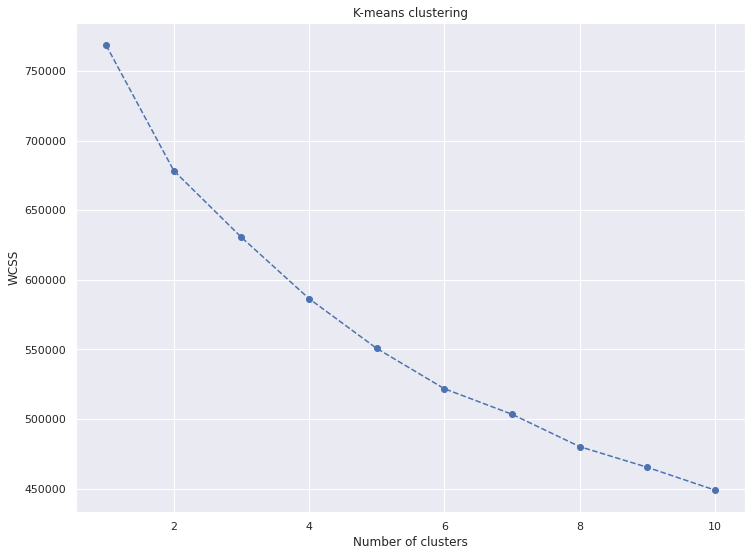

In [ ]:
#to check how many clusters needed
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (12,9))
plt.plot(range(1,11),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means clustering')
plt.plot()

In [ ]:
def s_score(model,segmentation_std,name):
    score = 0
    if name in ['k-means','birch','minibatch-kmeans']:
        score =  silhouette_score(segmentation_std, model.labels_)
    elif name in ["mean shift","optics","Agglomerative"]:
        score = silhouette_score(segmentation_std,model)
    else:
        score = silhouette_score(segmentation_std,model.predict(segmentation_std))
    print(f"score for {name} is {score}")
    return score


def benchmark_function(cluster_function, data, function_args, function_kwds,name = None):
    print("\n\n=============================================================================")
    print(f"here we benchmark for : {name}")
    stats = [name]
    queue = Queue()
    poll_interval = 0.1
    monitor_thread = Thread(target=memory_monitor, args=(queue, poll_interval,name))
    monitor_thread.start()
    try:
        s = time.time()
        model = cluster_function(data, *function_args, **function_kwds)
        e = time.time()
        stats.append(e-s)
        stats.append(model)
    finally:
        queue.put('stop')
        monitor_thread.join()

    return stats # nreturn time taken and memory profile snapshot



In [ ]:
time_elapsed = []
method = []
slscore = []
s = time.time()

In [ ]:

#k-means
k_means = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
k_means_data = benchmark_function(k_means.fit,segmentation_std,(), {},"k-means")
e = time.time()
slscore.append(s_score(k_means_data[-1],segmentation_std,"k-means"))
time_elapsed.append(e-s)
method.append('k-means')
print(f"k means time = {e-s}")





here we benchmark for : k-means
2022-06-15 06:01:12.721836
Top 3 lines
#1: utils/validation.py:746: 6004.7 KiB
    array = np.asarray(array, order=order, dtype=dtype)
#2: cluster/_kmeans.py:457: 2119.4 KiB
    lower_bounds = np.zeros((n_samples, n_clusters), dtype=X.dtype)
#3: cluster/_kmeans.py:456: 353.3 KiB
    upper_bounds = np.zeros(n_samples, dtype=X.dtype)
52 other: 0.0010201837867498398 GiB for k-means
Total allocated size: 0.009104786440730095 GiB for k-means
score for k-means is 0.12303315196389186
k means time = 2.0445101261138916


In [ ]:
#minibatch
b_means = MiniBatchKMeans(n_clusters=6, random_state = 42)
b_means_data = benchmark_function(b_means.fit,segmentation_std,(), {},"minibatch-kmeans")
e = time.time()
slscore.append(s_score(b_means_data[-1],segmentation_std,"minibatch-kmeans"))
time_elapsed.append(e-s)
method.append('minibatch-kmeans')
print(f"minibatch-kmeans time = {e-s}")





here we benchmark for : minibatch-kmeans
2022-06-15 06:01:36.456649
Top 3 lines
#1: utils/validation.py:746: 6004.7 KiB
    array = np.asarray(array, order=order, dtype=dtype)
#2: cluster/_kmeans.py:1921: 408.1 KiB
    X_valid = X[validation_indices]
#3: core/einsumfunc.py:1359: 353.3 KiB
    return c_einsum(*operands, **kwargs)
282 other: 0.0011971788480877876 GiB for minibatch-kmeans
Total allocated size: 0.007649836130440235 GiB for minibatch-kmeans
score for minibatch-kmeans is 0.09710877238323876
minibatch-kmeans time = 25.829875230789185


In [ ]:
#   birch 
s = time.time()
birch = Birch(threshold=0.01, n_clusters=6)
birch_data = benchmark_function(birch.fit,segmentation_std,(),{},"birch")
e = time.time()
print(f"birch time = {e-s}")
slscore.append(s_score(birch_data[-1],segmentation_std,"birch"))
time_elapsed.append(e-s)
method.append('birch')





here we benchmark for : birch
2022-06-15 06:04:32.991360
Top 3 lines
#1: utils/extmath.py:153: 1048331.3 KiB
    ret = a @ b
#2: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#3: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
433 other: 0.03001298662275076 GiB for birch
Total allocated size: 1.0526236733421683 GiB for birch
birch time = 160.0460238456726
score for birch is 0.09493450042092845


In [ ]:
# gmms
s = time.time()
gmm = GaussianMixture(n_components=6)
gmm_data = benchmark_function(gmm.fit,segmentation_std,(), {},"gmm")
e = time.time()
slscore.append(s_score(gmm_data[-1],segmentation_std,"gmm"))
print(f"gmm time = {e-s}")
time_elapsed.append(e-s)
method.append('GMM')




here we benchmark for : gmm
2022-06-15 06:05:01.344692
Top 3 lines
#1: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#2: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
#3: <__array_function__ internals>:6: 7132.0 KiB
473 other: 0.03188218828290701 GiB for gmm
Total allocated size: 0.061527772806584835 GiB for gmm
score for gmm is 0.10447205638333026
gmm time = 7.71349310874939


In [ ]:
# do not run this, its takes insane amount of time
#spectral clustering
# s = time.time()
# spect = SpectralClustering(n_clusters=8)
# spect_data = benchmark_function(spect.fit_predict,segmentation_std,(),{})
# e = time.time()
# time_elapsed.append(e-s)
# print(f"spectral time = {e-s}")
# method.append('spectral')
#mean shift 
s = time.time()
mean_shift = MeanShift(min_bin_freq = 1)
mean_shift_data = benchmark_function(mean_shift.fit_predict,segmentation_std,(),{},"mean shift")
e = time.time()
slscore.append(s_score(mean_shift_data[-1],segmentation_std,"mean shift"))
time_elapsed.append(e-s)
print(f"MeanS hift time = {e-s}")
method.append('mean shift')




here we benchmark for : mean shift
2022-06-15 06:35:00.083635
Top 3 lines
#1: utils/extmath.py:153: 176653.1 KiB
    ret = a @ b
#2: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#3: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
507 other: 0.02967233397066593 GiB for mean shift
Total allocated size: 0.22098586149513721 GiB for mean shift
score for mean shift is 0.39384637347006024
MeanS hift time = 1778.6100211143494


# ignore this if last cell output is present !

(god bless you)

last execution result for mean shift 

here we benchmark on bank dataset for : mean shift
2022-06-14 22:34:07.119238
Top 3 lines
#1: utils/extmath.py:153: 176652.8 KiB
    ret = a @ b
#2: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#3: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
399 other: 0.029468164779245853 GiB for mean shift

Total allocated size: 0.22078145388513803 GiB for mean shift

MeanS hift time = 2696.1197464466095


In [ ]:
#optics 
s = time.time()
optics = OPTICS(eps=0.8, min_samples=10)
optics_data = benchmark_function(optics.fit_predict,segmentation_std,(),{},"optics")
e = time.time()
slscore.append(s_score(mean_shift_data[-1],segmentation_std,"optics"))
time_elapsed.append(e-s)
print(f"optics time : {e - s }")
method.append('optics')




here we benchmark for : optics
2022-06-15 07:08:10.989977
Top 3 lines
#1: utils/extmath.py:153: 1048378.1 KiB
    ret = a @ b
#2: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#3: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
778 other: 0.03488505817949772 GiB for optics
Total allocated size: 1.057540314272046 GiB for optics
score for optics is 0.39384637347006024
optics time : 951.1588716506958


In [ ]:

s = time.time()
aglo = AgglomerativeClustering(n_clusters=6)
aglo_data = benchmark_function(aglo.fit_predict,segmentation_std,(),{},"Agglomerative")
e = time.time()
slscore.append(s_score(mean_shift_data[-1],segmentation_std,"Agglomerative"))
print(f"aglo clustering time: {e-s}")
method.append('Agglomerative')
time_elapsed.append(e-s)





here we benchmark for : Agglomerative
2022-06-15 07:13:49.903066
Top 3 lines
#1: spatial/distance.py:2004: 7984333.3 KiB
    dm = np.empty((m * (m - 1)) // 2, dtype=np.double)
#2: cluster/_birch.py:297: 13053.9 KiB
    self.child_ = None
#3: cluster/_birch.py:154: 10899.8 KiB
    self.init_centroids_ = np.zeros((branching_factor + 1, n_features))
780 other: 0.0404219888150692 GiB for Agglomerative
Total allocated size: 7.677719634026289 GiB for Agglomerative
score for Agglomerative is 0.39384637347006024
aglo clustering time: 113.98634028434753


In [ ]:
run_time = dict(zip(method,time_elapsed))
sscore_dict = dict(zip(method,slscore))
print(run_time)

{'k-means': 2.0445101261138916, 'minibatch-kmeans': 25.829875230789185, 'birch': 160.0460238456726, 'GMM': 7.71349310874939, 'mean shift': 1778.6100211143494, 'optics': 951.1588716506958, 'Agglomerative': 113.98634028434753}


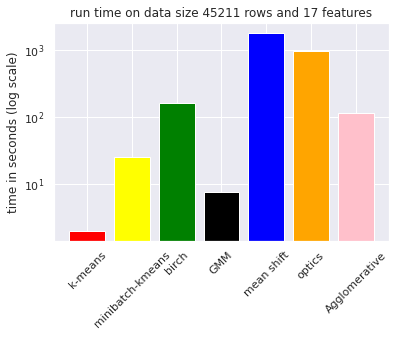

In [ ]:
plt.yscale('log')
plt.bar(range(len(run_time)), list(run_time.values()), align='center',color = ['red', 'yellow','green','black', 'blue', 'orange','pink'])
plt.xticks(range(len(run_time)), list(run_time.keys()),rotation = 45)
plt.ylabel("time in seconds (log scale)")
plt.title("run time on data size 45211 rows and 17 features")
plt.show()

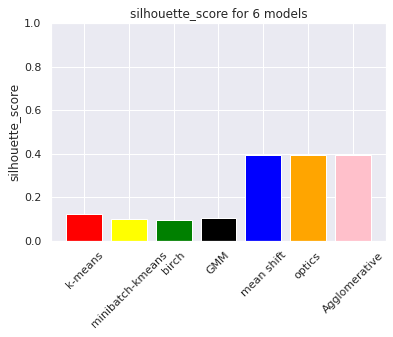

In [ ]:
plt.bar(range(len(sscore_dict)), list(sscore_dict.values()), align='center',color = ['red', 'yellow','green','black', 'blue', 'orange','pink'])
plt.xticks(range(len(sscore_dict)), list(sscore_dict.keys()),rotation = 45)
plt.ylabel("silhouette_score")
plt.ylim(0,1)
plt.title("silhouette_score for 6 models")
plt.show()